**[Deep Learning Home Page](https://www.kaggle.com/learn/deep-learning)**

---


## Tom Segal's "Petal to the Metal" competition entry - https://www.kaggle.com/c/tpu-getting-started ## 

features include:

2d colorful image identification using:
- TPUs
- oversampling
- augmentation
- pretraining
- warmup layers
- variable learning function
- early stopping

this notebook is a result of researching and borrowing of content from other notebooks. I learned a lot creating it and I acknowledge the support of this great community for my learning experience.

I specifically learned a lot by using these notebooks:

https://www.kaggle.com/yihdarshieh/detailed-guide-to-custom-training-with-tpus

https://www.kaggle.com/philculliton/a-simple-petals-tf-2-2-notebook

https://www.kaggle.com/dimitreoliveira/flower-classification-with-tpus-eda-and-baseline

and of course the provided documentation from Kaggle:

https://www.kaggle.com/ryanholbrook/create-your-first-submission

https://www.kaggle.com/c/tpu-getting-started

https://www.kaggle.com/c/tpu-getting-started/data

https://www.kaggle.com/ryanholbrook/petal-helper


more useful resources:

the available pre-trained models https://keras.io/api/applications/ of which I used Xception, VGG16 and DenseNet201

https://www.kaggle.com/timoboz/data-science-cheat-sheets





## import ##

In [1]:
# there is a library of helper functions for this challenge, petal_helper, which was not used. One can import it using:
# from petal_helper import *
# documentation at https://www.kaggle.com/ryanholbrook/petal-helper

from kaggle_datasets import KaggleDatasets # used to retrieve the dataset
import tensorflow as tf
import re
import math
import numpy as np
import os
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import gridspec
import itertools
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
print("the version of Tensorflow currently used is " + tf.__version__)
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
from tensorflow.keras import optimizers

the version of Tensorflow currently used is 2.2.0


define the randomness

In [2]:
seed = 0 # the random seed to be used. a fixed seed helps comparing results in a more systematic manner.
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

a list of the flower classes, copy-pasted from the petal-helper library.

In [3]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

## retrieve TPU ##

In [4]:
# this code tries to retrieve a TPU and then sets TensorFlow to use the accelerator that we get,
# so if we don't get a TPU it will get a GPU or a CPU and run Tensorflow on it
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


we see that as an output we got "Running on TPU" so we did get a TPU to run Tensorflow on. Replicas 8 means we have 8 TPUs to work on.

get the path to the dataset. the data structure is shown here:
https://www.kaggle.com/c/tpu-getting-started/data

In [5]:
# note that we could have also used the get_gcs_path function from petal-helper
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') 
print(GCS_DS_PATH)

gs://kds-932bebb4a57fe9d9fa3f0c4d837fada770b5686b31dfe504ba996ef4


select the data. the flower pictures come in 4 different sizes. here 192x192, the lowest size, was used, in order to have faster running times, and because the performance of the different strategies is expected to scale monotonously with the picture size, such that the strategy comparison written at the end remains valid.

In [6]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
# Select the dataset containing the size we chose above
IMAGE_SIZE = [192,192]
HEIGHT = IMAGE_SIZE[0]
WIDTH = IMAGE_SIZE[1]
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

helper functions for loading the datasets

next the datasets will be loaded. There are three, train, validation and test. They will be mapped according to read_labeled_tfrecord and read_unlabeled_tfrecord according to whether they are labeled (train, validation) or not (test). Both functions rely on decode_image to decode the images. 


The TFRecord format is a container format frequently used in Tensorflow to group and shard data data files for optimal training performace.
Each file contains the id, label the class of the sample, for training data) and img (the actual pixels in array form) information for many images.

In [7]:
# decode_image decodes image_data into a 3-channeled (RGB) JPEG, normalizes the values to a [0,1] float range
# and reshapes it into the given size 
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU. The "*" turns the *[192,192] to 192,192.
    return image

# read_labeled_tfrecord reads example and returns its splitted components image and label.
def read_labeled_tfrecord(example):
    # define the expected format: image, a tf.string, and class, a tf.int64.
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    # parse example
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    # decode the image and cast the label obtained from example and return them
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

# read_unlabeled_tfrecord reads example and returns its splitted components image and id.
def read_unlabeled_tfrecord(example):
    # define the expected format: image, a tf.string as before, but in addition id, a tf.string, instead of class.
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    # parse example
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    # decode the image and return both it and the id obtained from example and return them
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)


## load the data ##

In [8]:
# loadData is a general function which will be used for loading all three datasets.
# filePaths are the paths of the tfrecords to be loaded. labeled defines which mapping function to use
# ordered determines whether to read at a random order, which then speeds up the process.
def loadData(filePaths , labeled = True , ordered = False):
    # multiple files are read simultaneously at random order by default in order to speed things up in case not ordered.
    if not ordered:
        tf.data.Options().experimental_deterministic = False # read at random order
    dataset = tf.data.TFRecordDataset(filePaths) # read from multiple files simulataneously
    dataset = dataset.with_options(tf.data.Options()) # read data as it is streamed and not in its original order if set
    # if labeled = True, return pairs of (image, label) otherwise (image, id)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    return dataset

# dataAugment augments the data by receiving the images and their labels and performing a set of random modifications
# on the images before returning them.
# data augmentation was attempted but ultimately not used. 
def dataAugment(image, label):
    image = tf.image.random_flip_left_right(image, seed=seed) # randomly flip the image horizontally 
    image = tf.image.random_flip_up_down(image, seed=seed) # randomly flip the image vertically
    #image = tf.image.random_saturation(image, 0,2, seed=seed) 
    #image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
    #image = tf.image.random_contrast(image, lower=.5, upper=1.5, seed=seed)
    #image = tf.image.random_brightness(image, max_delta=0.8, seed=seed)
    #image = tf.image.random_crop(image, size=[int(HEIGHT*.8), int(WIDTH*.8), 3], seed=seed)
    return image, label


dataSetTrainPathString = GCS_PATH + "/train/*.tfrec" # define the file paths of the training data
dataSetTrainPaths = tf.io.gfile.glob(dataSetTrainPathString) # obtain all of these file paths
# (tf.io.gfile.glob retrieves all the files that match the string in the folder)
dataTrain = loadData(dataSetTrainPaths, labeled = True, ordered = False) # load the training data

# augments the data by creating different versions of it with different modifications as explained above.
# note that this was experimented with but not used.
# dataTrain = dataTrain.map(dataAugment, num_parallel_calls = tf.data.experimental.AUTOTUNE)
# dataTrain = dataTrain.repeat() # set the train data to repeat so it repeats for several epochs.
# note that repeat is commented-out because setting the dataTrain to repeat at this stage will cause problems in the
# data visualiation sections later on. So we turn it off for now and turn it on later.
# for example setting it to repeat causes an infinite loop while counting the labels below.
# the training data will be shuffled, such that the network will train on images in different order for each epoch.
# it is done by using the following line. However we don't do this at this stage because it would interfere with analysing
# the data beforehand.
# dataTrain = dataTrain.shuffle(2048) # shuffle such that we will train on images in different order in each epoch
# the training data will be batched in recommended batch sizes of 16 times the TPU units in order for the TPUs
# to be able to handle them more efficiently. This will be 16 with TPU off and 16*8=128 with TPU on
batchSize = 16 * strategy.num_replicas_in_sync
dataTrain = dataTrain.batch(batchSize)
# prefatch the next batch while training to improve speed.
# note that tf.data.experimental.AUTOTUNE means that the API will read from multiple files if they are available
dataTrain = dataTrain.prefetch(tf.data.experimental.AUTOTUNE)
print("train data: " , dataTrain) # display the training data shapes

# load the validation data. Similar to the training data only that no augmentation was considered,
# and theres no shuffling.
dataSetValPathString = GCS_PATH + "/val/*.tfrec"
dataSetValPaths = tf.io.gfile.glob(dataSetValPathString)
dataVal = loadData(tf.io.gfile.glob(dataSetValPaths) , labeled = True , ordered = True)
# it is not needed to repeat the val data as we don't train on them, but we would still like
# to feed them in batches to make the TPU work at optimal speed
dataVal = dataVal.batch(batchSize)
dataVal = dataVal.cache() # caches the elements of the dataset in memory
dataVal = dataVal.prefetch(tf.data.experimental.AUTOTUNE)
print("validation data: " , dataVal)

# load the test set.
# note that this dataset is not augmented, shuffled, cached or labeled.
dataSetTestPathString = GCS_PATH + "/test/*.tfrec"
dataSetTestPaths = tf.io.gfile.glob(dataSetTestPathString)
dataTest = loadData(dataSetTestPaths , labeled = False , ordered = True)
dataTest = dataTest.batch(batchSize)
dataTest = dataTest.prefetch(tf.data.experimental.AUTOTUNE)
print("test data: " , dataTest)


train data:  <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
validation data:  <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
test data:  <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.string)>


count the number of images in each dataset

In [9]:
myStr = "flowers00-230.tfrec"
print(myStr)
print(str(re.compile(r"-([0-9]*\.)").search(myStr).group(1)))

flowers00-230.tfrec
230.


In [10]:
# count_data_items counts the amount of items in filenames.
def count_data_items(filenames):
    # due to the filename structure of i.e. flowers00-230.tfrec, the number is located in the file name: 230
    # a re (regular expression) is used to locate the number:
    # r"something" means "something" is handled in raw string notiation which means "\" are not handled in any special way
    # "-" means look for a "-", but don't consider it a part of the re as it is outside the round brackets ()
    # [0-9] means any single digit
    # [0-9]* means any number of single digits in a row
    # \. means look for "." ("\" is used here as an escape character)
    # this way one obtains i.e. flowers00-230.tfrec = 230 data items
    # see https://docs.python.org/3/library/re.html
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# calculate the number of images for each set. Note that the number of images for the train data is called
# originalNumTrainImages and not numTrainImages as oversampling and augmentation was experimented with.
originalNumTrainImages = count_data_items(dataSetTrainPaths)
numValImages = count_data_items(dataSetValPaths)
numTestImages = count_data_items(dataSetTestPaths)

print ("Number of training images: {}".format(originalNumTrainImages))
print ("Number of validation images: {}".format(numValImages ))
print ("Number of test images: {}".format(numTestImages))

Number of training images: 12753
Number of validation images: 3712
Number of test images: 7382


the result: 12753 train, 3712 validation and 7382 test images.

label counting

it is important to check whether the labels are evenly represented




In [11]:
# getLabelCounting counts the number of appearances of each lebel in labeled_database.
# tf.autograph.experimental.do_not_convert prevents tf from converting this function into a graph in order
# to supress errors. This is ok because the function is not used as part of the input for the machine learning procedure.
@tf.autograph.experimental.do_not_convert
def getLabelCounting(labeled_dataset):
    c = Counter() # labels counter
    labels = []
    # retrieve the different batches from the labeled_dataset. For each one, append it to the labels array
    # after filling up the labels array, concatenate it and update the counter with the labels.
    for batch in labeled_dataset.map(lambda image, label: label, num_parallel_calls=tf.data.experimental.AUTOTUNE):
        labels.append(batch)
    labels = tf.concat(labels, axis=0).numpy()
    c.update(labels)
    return labels, c
# if we call getLabelCounting using dataTrain while dataTrain is set to repeat we will get an infinite loop
# but because it is commented-out above it is safe to execute this and we need to remember to set trainData
# to repeat down below

dataTrainLabelsIndex , dataTrainLabelsCount = getLabelCounting(dataTrain)
dataValLabelsIndex , dataValLabelsCount = getLabelCounting(dataVal)

plot the label distribution

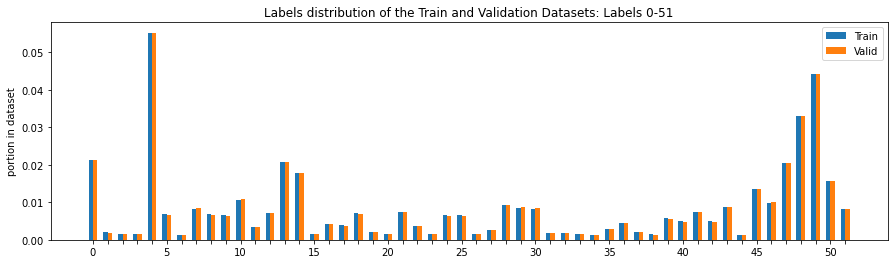

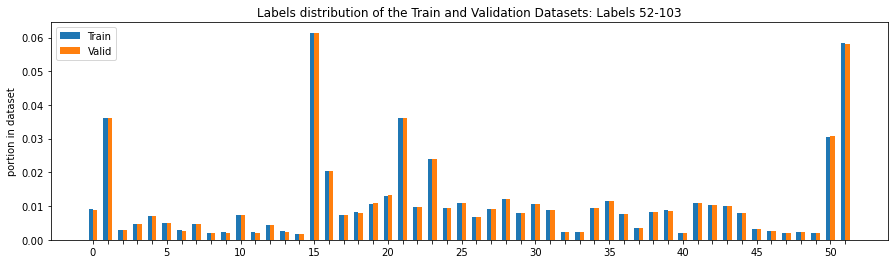

In [12]:
# plot_label_dist plots the label distributions dist_1 and dist_2 (named dist_label_1 and dist_label_2)
# of the labels set labels
def plot_label_dist(labels, dist_1, dist_2, dist_label_1, dist_label_2, title=''):
    
    x = np.arange(len(labels)) # the horizontal axis, as in the label locations
    width = 0.3 # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 4)) # height and width of the plots
    # offset the plots from one another by width to make them more readable
    rects1 = ax.bar(x - width / 2, dist_1, width, label=dist_label_1)
    rects2 = ax.bar(x + width / 2, dist_2, width, label=dist_label_2)

    ax.set_ylabel('portion in dataset') # vertical axis name
    ax.set_title(title) # graph name
    ax.set_xticks(x) # horizontal axis ticks
    ax.set_xticklabels([str(x) if x % 5 in [0] else '' for x in range(len(labels))] ) # horizontal axis tick names
    ax.legend() # add a legend at the top right
    plt.show()
    plt.close()
    
labels = list(range(len(CLASSES))) # convert the classes into a list of numberss
distTrain = [dataTrainLabelsCount[x] / originalNumTrainImages for x in labels] # the label dist for the train data
distVal = [dataValLabelsCount[x] / numValImages for x in labels] #  # the label dist for the validation data

half = len(labels) // 2  # plot in 2 separate plots

# plot the first half
plot_label_dist(
    labels[:half],
    distTrain[:half],
    distVal[:half],
    'Train',
    'Valid',
    title='Labels distribution of the Train and Validation Datasets: Labels 0-{}'.format(half - 1)
)

# plot the second half
plot_label_dist(
    labels[half:],
    distTrain[half:],
    distVal[half:],
    'Train',
    'Valid',    
    title='Labels distribution of the Train and Validation Datasets: Labels {}-{}'.format(half, len(labels) - 1)
)

numerical representation:

In [13]:
print(dataTrainLabelsCount)

Counter({67: 782, 103: 743, 4: 703, 49: 563, 73: 460, 53: 460, 48: 422, 102: 390, 75: 306, 0: 272, 13: 263, 47: 261, 68: 260, 14: 227, 50: 201, 45: 172, 72: 167, 80: 153, 87: 146, 77: 139, 93: 139, 71: 137, 10: 136, 82: 134, 94: 131, 95: 127, 46: 125, 74: 125, 86: 120, 28: 119, 76: 119, 79: 118, 52: 115, 83: 112, 91: 111, 43: 110, 29: 109, 90: 106, 30: 105, 51: 105, 7: 105, 70: 104, 81: 101, 96: 100, 21: 96, 88: 96, 41: 96, 69: 94, 62: 93, 12: 92, 18: 90, 56: 89, 8: 87, 5: 87, 78: 86, 24: 85, 9: 84, 25: 83, 39: 73, 40: 64, 57: 63, 42: 63, 59: 58, 55: 58, 36: 57, 64: 55, 16: 55, 17: 50, 22: 48, 89: 46, 11: 43, 97: 41, 54: 37, 35: 36, 58: 36, 27: 34, 98: 34, 65: 33, 84: 31, 100: 31, 61: 29, 85: 29, 63: 28, 60: 27, 1: 26, 19: 26, 37: 26, 101: 25, 92: 24, 31: 24, 99: 24, 32: 23, 66: 21, 26: 21, 15: 21, 3: 21, 2: 20, 33: 20, 23: 19, 20: 19, 38: 19, 34: 18, 6: 18, 44: 18})


we see that the labels are not distributed evenly. Some have 6% of the pictures while others have about a tenth of that. To balance that we could either create weights with larger weights for under-represented labels ("class weights"), or repeating the pictures of the under-represented labels ("oversampling".
These two options would have practically identical results, but seeing how we are working in batches, it is better to oversample as the change is more spread out across batches and thus provides a smoother gradient signal.

we see that lebel 67 appears 782 times while label 44 appears only 18 times
next we decide whats the minimal occurance of each class that we want to have. We could choose any number between 18 and 782. If we choose 18 we would not duplicate any images, and if we choose 782 we will duplicate the maximum amount of images. We don't need it to be completely balanced and maybe by doing so we also overdo it with the oversampling.
So instead we will choose 200.


define the functions necessary for oversampling the train data.

In [14]:
# get_num_to_repeat_for_class calculates the number of times a training data with label label class_id
# should be repeated to reach target_counting appearances total. Calling this function for all class ids will
# result in a training datasetwhere  each class occurs more or less target_counting times.
# "more or less" because the number returned has some randomness to it.
def get_num_to_repeat_for_class(class_id, target_counting):
    # count how many train images we have of the class class_id
    counting = dataTrainLabelsCount[class_id]
    
    # if the class already has at least target_counting appearances return 1 which means nothing needs to be done.
    if counting >= target_counting:
        return 1.0
    # otherwise the ratio between the desired and existing appearances is the desired ratio
    num_to_repeat = target_counting / counting
    return num_to_repeat

# get_nums_to_repeat calls get_num_to_repeat_for_class for every class in order to obtain the number of necessary
# occurences for each image in every class in order for the entire dataset to have all of its labels being
# more or less equally represented target_counting times
def get_nums_to_repeat(target_counting):
    """Compute a table that stores the results of `get_num_to_repeat_for_class`
       for every class and for the given `target_counting`.
    
    Args:
        target_counting: int, the targeted occurrence number.
    
    Returns:
        table: A `tf.lookup.StaticHashTable`.
        d: A dictionary storing the same information as `table`.
    """
    
    keys = range(len(CLASSES)) # numerical representation of the different classes/labels
    # calculate the number of appearances each class needs to have in order to reach
    #   a uniform distribution of target_counting
    values = [get_num_to_repeat_for_class(x, target_counting) for x in keys]

    keys_tensor = tf.constant(keys) # the label indices are saved in a keys tensor
    vals_tensor = tf.constant(values) # the values for each label are saved in a values tensor
    
    # a static hash table of type tf.lookup.StaticHashTable is initialized with the keys and values 
    table_initializers = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
    
    table = tf.lookup.StaticHashTable(table_initializers, default_value=0.0)
    # the static hash table is stored into a dictionary 
    d = {k: v for k, v in zip(keys, values)}

    return table, d

# get_num_to_repeat_for_example uses the table calculated by get_nums_to_repeat, which contains inprecise, float
# values, in order to calculate final, int values, which also contain an element of randomness
# example is a training data example, a tuple of 2 tensors, image and label.
def get_num_to_repeat_for_example(example, table):
    """Compute the actual number of times a training example will repeat
       in order to get a dataset where each class occur <approximately> 
       N times with N being a pre-defined number that is used for constructing
       `table`.

    Args:
        example: A tuple of 2 tensors, which is a labeled training example and
            represented as (image, label).
                          
        tabel: A tf.lookup.StaticHashTable, as obtained from `get_nums_to_repeat`.
                          
    Returns:
        A tf.int64 scalar tensor, the number of times `example` will repeat.
    """
    
    image, label = example
    num_to_repeat = table.lookup(label) # obtain the non-final repetition number for this label    
    num_to_repeat_integral = tf.cast(int(num_to_repeat), tf.float32) # cast it into an int and save it separately
    # With a probability `residue`, we allow `example` to repeat one more time.
    residue = num_to_repeat - num_to_repeat_integral # calculate the difference between the float and the int
    # randomly decide in which direction to round it
    num_to_repeat = num_to_repeat_integral + tf.cast(tf.random.uniform(shape=()) <= residue, tf.float32)
    return tf.cast(num_to_repeat, tf.int64)

calculate the number of times each picture should be repeated for each label. Note that this is the exact number, as in, a float.
I tried N=200 but saw the data set still looked very non-uniform so I went up to 400. I did not want to select too large of a number like 600 or 700 in order to not overdo with the oversampling.

In [15]:
numOfRepetitions = 400
_, d = get_nums_to_repeat(numOfRepetitions) # retrieve the repetitions dictionary (don't save the static hash table)
d = sorted(d.items(), key=lambda x: x[1], reverse=True) # sort in reverse order according to the value

print('how many repetitions for every label? (class id, num to repeat)\n')
for x in d:
    print(x)

how many repetitions for every label? (class id, num to repeat)

(6, 22.22222222222222)
(34, 22.22222222222222)
(44, 22.22222222222222)
(20, 21.05263157894737)
(23, 21.05263157894737)
(38, 21.05263157894737)
(2, 20.0)
(33, 20.0)
(3, 19.047619047619047)
(15, 19.047619047619047)
(26, 19.047619047619047)
(66, 19.047619047619047)
(32, 17.391304347826086)
(31, 16.666666666666668)
(92, 16.666666666666668)
(99, 16.666666666666668)
(101, 16.0)
(1, 15.384615384615385)
(19, 15.384615384615385)
(37, 15.384615384615385)
(60, 14.814814814814815)
(63, 14.285714285714286)
(61, 13.793103448275861)
(85, 13.793103448275861)
(84, 12.903225806451612)
(100, 12.903225806451612)
(65, 12.121212121212121)
(27, 11.764705882352942)
(98, 11.764705882352942)
(35, 11.11111111111111)
(58, 11.11111111111111)
(54, 10.81081081081081)
(97, 9.75609756097561)
(11, 9.30232558139535)
(89, 8.695652173913043)
(22, 8.333333333333334)
(17, 8.0)
(16, 7.2727272727272725)
(64, 7.2727272727272725)
(36, 7.017543859649122)
(55, 6.896

## oversampling ##

In [16]:
# get_oversampled_training_dataset uses loadData to load the training data set and then creates a modified version
# of it dataset which is oversampled such that each class has approximately target_counting repetitions.
# oversample determines whether to oversample or not. The oversampled data can be augmented using an augmentation
# function augmentation_fn which is performed with probability probability.can be used to augment the oversampled data
# using an augmentation function. the oversampled dataset can be set to repeat using repeat_dataset, to be ordered
# using ordered and if not ordered is shuffled according to shuffle_buffer_size. It is also batched using batch_size.
def get_oversampled_training_dataset(
        target_counting, batch_size, shuffle_buffer_size,
        repeat_dataset=False, ordered=False,
        oversample=True, augmentation_fn=None, probability=1.0
    ):
    """
    Construct an oversampled dataset in which each class occurs approximately
    `target_counting` times.
    
    (Special) Args:
    
        target_counting: int, the target occurrence.
        oversampe: bool, if to use oversampling. If `False`, no oversampliing and
            the arguement `target_counting` has no effect.
        augmentation_fn: A funtion used to map the dataset for data augmentation.
        probability: float, the probability to perform the augmentation
        
    Returns:
        A tf.data.Dataset.
    """
    # retrieve the repetitions table and dictionary for the different classes
    table, d = get_nums_to_repeat(target_counting)
    
    nb_examples = originalNumTrainImages # nb_examples initially holds the original number of training images
    
    dataset = loadData(dataSetTrainPaths, labeled=True, ordered=ordered) # load the training data set

    if oversample:
        # if oversampling, nb_examples holds an approximation of the number of images in the oversampled dataset
        nb_examples = int(sum([dataTrainLabelsCount[k] *  v for k, v in d.items()]))
        # map the different images in the dataset to repeat, each with its appropriate number of repetitions
        dataset = dataset.flat_map(
            lambda image, label: tf.data.Dataset.from_tensors((image, label)).repeat(get_num_to_repeat_for_example((image, label), table))
        )
        
    if repeat_dataset: # if set to repeat, do so.
        dataset = dataset.repeat()
 
    # if not set to be ordered, shuffle it, either according to the given shuffle buffer size or according to the
    # number of training images
    if not ordered:
        if not shuffle_buffer_size:
            shuffle_buffer_size = nb_examples
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size, drop_remainder=True) # separate the dataset into batches
    
    if augmentation_fn: # if an augmentation is given, augment the data with the given probability for each image
        probability = tf.constant(probability, dtype=tf.float32)
        dataset = dataset.map(
            lambda images, labels: augmentation_fn(images, labels, probability=probability),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the next batch while processing to impro
    
    return dataset, nb_examples

# call get_oversampled_training_dataset and store the oversampled dataset in dataTrainOversampled
dataTrainOversampled, _ = get_oversampled_training_dataset(target_counting=numOfRepetitions, batch_size=16, shuffle_buffer_size=1, repeat_dataset=False, ordered=True, oversample=True, augmentation_fn=None)


_, oversampled_train_counter = getLabelCounting(dataTrainOversampled) # count the number of appearances of each label
NUM_OVERSAMPLED_TRAINING_DATA = sum(oversampled_train_counter.values()) # sum them to arrive at the total dataset size
print('Oversampled training dataset:\ntraining images: {}\n'.format(NUM_OVERSAMPLED_TRAINING_DATA)) # print it

print("labels in the oversampled training dataset, sorted by occurrence: pairs of (label_id, label_counting)\n")
print(oversampled_train_counter.most_common())

print('\n' + 'averaged number of occurrences: ', np.array(list(oversampled_train_counter.values())).mean())

Oversampled training dataset:
training images: 42912

labels in the oversampled training dataset, sorted by occurrence: pairs of (label_id, label_counting)

[(67, 781), (103, 742), (4, 703), (49, 562), (73, 460), (53, 460), (48, 422), (78, 415), (91, 411), (95, 409), (28, 406), (18, 406), (30, 406), (29, 406), (7, 406), (12, 405), (19, 404), (37, 404), (70, 403), (77, 403), (71, 403), (45, 403), (69, 403), (5, 403), (99, 403), (54, 403), (22, 402), (64, 402), (1, 402), (81, 402), (15, 402), (97, 402), (65, 402), (50, 401), (32, 401), (16, 401), (27, 401), (66, 401), (88, 401), (84, 401), (11, 401), (31, 401), (24, 401), (26, 401), (6, 401), (62, 401), (72, 400), (0, 400), (21, 400), (101, 400), (83, 400), (96, 400), (76, 400), (74, 400), (100, 400), (41, 400), (17, 400), (34, 400), (2, 400), (36, 400), (3, 400), (33, 400), (44, 400), (38, 400), (10, 399), (8, 399), (92, 399), (9, 399), (39, 399), (80, 399), (23, 399), (35, 399), (20, 399), (58, 399), (82, 398), (13, 398), (61, 398), (4

we now have 42912 instead of 12753 training images, about 3-4 times as much.

as a result the new oversampled data has on average 412 pictures per label. Note that due to a random factor not all labels have at least 400 but rather a number around that.

comparison to what we had before:

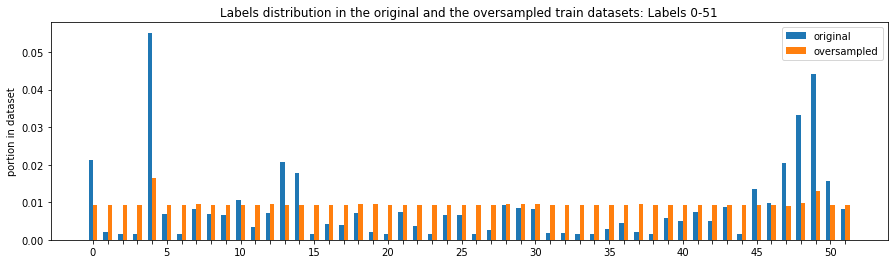

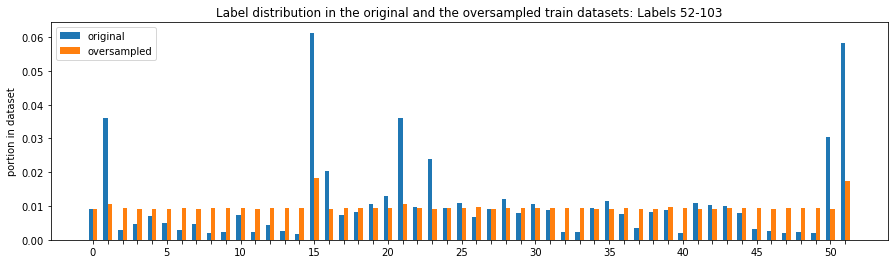

In [17]:
dist_train_oversampled = np.array([oversampled_train_counter[x] for x in labels]) / sum(oversampled_train_counter.values())

half = len(labels) // 2
plot_label_dist(
    labels[:half], distTrain[:half], dist_train_oversampled[:half],'original','oversampled',
    title='Labels distribution in the original and the oversampled train datasets: Labels 0-{}'.format(half - 1)
)

plot_label_dist(
    labels[half:],distTrain[half:],dist_train_oversampled[half:],'original','oversampled',    
    title='Label distribution in the original and the oversampled train datasets: Labels {}-{}'.format(half, len(labels) - 1)
)

the dataset is now significantly more balanced. At first I chose numOfRepetitions=200 and show that there were still large differences, so I changed it to numOfRepetitions=400.
Note that we only changed the train dataset, not the validation dataset, so that now theres a big difference between their distributions.

## visualize the oversampled dataset ##

visualization functions

In [18]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return '{} {}'.format(CLASSES[label], label) , True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(
        '{} {}'.format(CLASSES[label], label),
        'OK' if correct else 'NO',
        u"\u2192" if not correct else '',
        '{} {}'.format(CLASSES[correct_label], correct_label) if not correct else ''
    ), correct

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

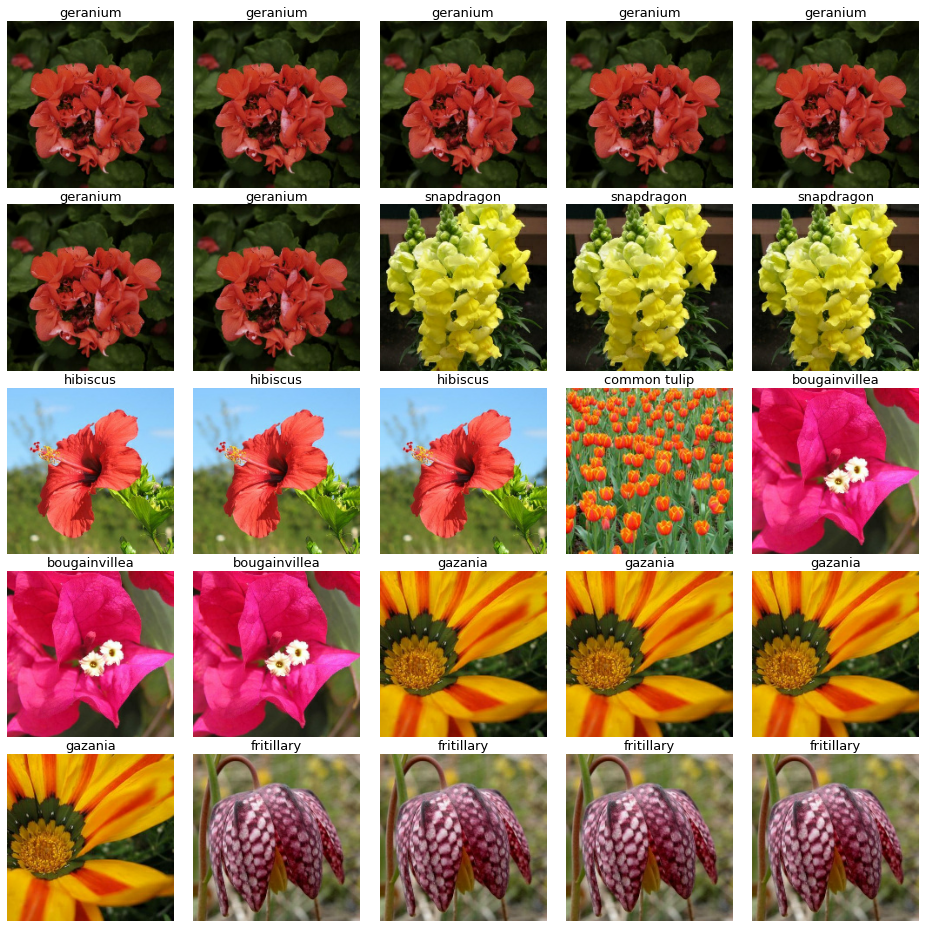

In [19]:
dataTrainOversampledBatch = next(iter(dataTrainOversampled.unbatch().batch(25)))
display_batch_of_images(dataTrainOversampledBatch)

note that the duplicate images all appear one after the other. It is therefore also important to shuffle the oversampled data. It is also advantageous to augment it.

In [20]:
# augment the oversampled data, set it to repeat and shuffle it
dataTrainOversampledModified = dataTrainOversampled.map(dataAugment, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataTrainOversampledModified = dataTrainOversampledModified.repeat() # set the train data to repeat so it repeats for several epochs                                                              
dataTrainOversampledModified = dataTrainOversampledModified.shuffle(2048) # shuffle 2048 such that the network will train on images in differenet order
# batch and prefetch it
dataTrainOversampledModified = dataTrainOversampledModified.batch(batchSize)
dataTrainOversampledModified = dataTrainOversampledModified.prefetch(tf.data.experimental.AUTOTUNE)


## visualize the validation dataset ##

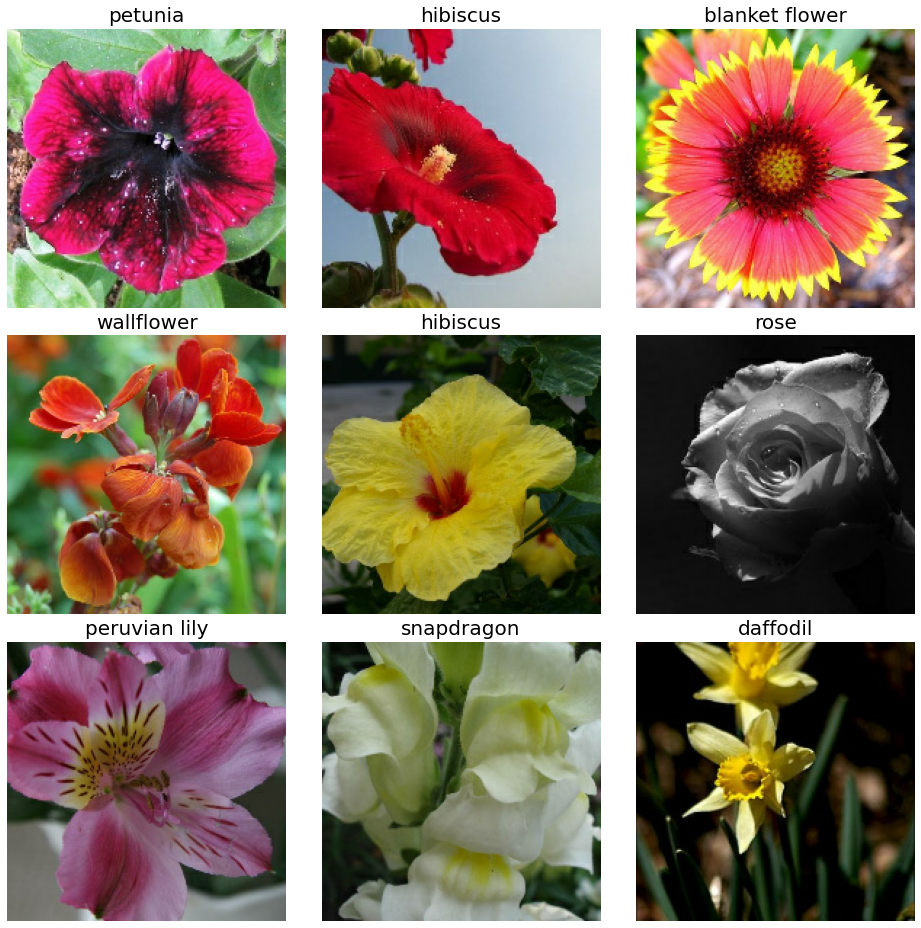

In [21]:
display_batch_of_images(next(iter(dataVal.unbatch().batch(9))))

## visualize the test dataset ##

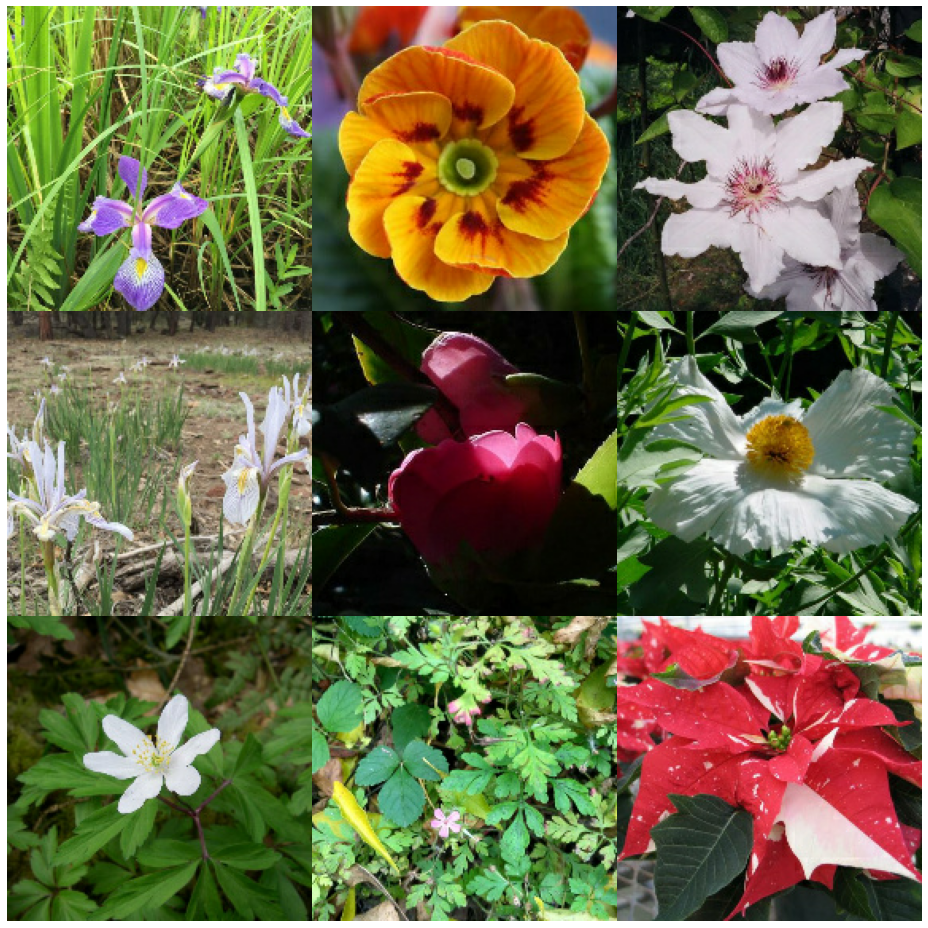

In [22]:
display_batch_of_images(next(iter(dataTest.unbatch().batch(9))))

## define model ##
next the model will be defined.

In this project I tried VGG16, Xception and DenseNet201, all are pretrained models of imagenet.

In [23]:
# we use warmup epochs, which are a few epochs in the beginning with especially high learning rates in order to
# help the model to settle in around the global minimum area

WARMUP_LEARNING_RATE = 1e-4 * strategy.num_replicas_in_sync
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
metric_list = ['sparse_categorical_accuracy']

with strategy.scope():
    # the model used is a pretrained model using the weights of imagenet
    #pretrained_model = tf.keras.applications.VGG16(
    #pretrained_model = tf.keras.applications.Xception(
    pretrained_model = tf.keras.applications.DenseNet201(
        weights='imagenet',
        # we set include_top to False because we are adding our own top.
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3] # the input shape is set to 192,192,3
    )
    pretrained_model.trainable = False # setting pretrained_model.trainable to False means that we use transfer learning.
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier, a GlobalAveragePooling2D and a dense layer
        # with a size fitting the output size, 104.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    # use the adam model optimizer with lr=warmUpLearningRate, loss sparse_categorical_crossentropy and metric sparse_categorical_accuracy
    #model.compile(
    #    optimizer='adam',
    #    loss = 'sparse_categorical_crossentropy',
    #    metrics=['sparse_categorical_accuracy'],
    model.compile(
        optimizer= optimizer,
        loss = 'sparse_categorical_crossentropy',
        metrics= metric_list,
    )

model.summary()

74842112/74836368 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 6, 6, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 199,784
Non-trainable params: 18,321,984
_________________________________________________________________


## train model ##

In [24]:
# before training the model we will pre-train it for a small number of epochs - warmup
STEPS_PER_EPOCH = originalNumTrainImages // batchSize
WARMUP_EPOCHS = 3
dataTrain = dataTrain.repeat() # don't forget to set dataTrain to repeat like we planned to
warmup_history = model.fit(x=dataTrain, 
                           steps_per_epoch=STEPS_PER_EPOCH, 
                           validation_data=dataVal,
                           epochs=WARMUP_EPOCHS, 
                           verbose=2).history

Epoch 1/3
99/99 - 37s - sparse_categorical_accuracy: 0.3812 - loss: 2.8255 - val_sparse_categorical_accuracy: 0.6107 - val_loss: 1.8093
Epoch 2/3
99/99 - 14s - sparse_categorical_accuracy: 0.7016 - loss: 1.3927 - val_sparse_categorical_accuracy: 0.7279 - val_loss: 1.2464
Epoch 3/3
99/99 - 14s - sparse_categorical_accuracy: 0.7895 - loss: 0.9825 - val_sparse_categorical_accuracy: 0.7664 - val_loss: 1.0266


define a learning rate function lrfn which has a linearly increasing learning rate for the first 3 epochs and an exponentially decreasing one for the following epochs.

Learning rate schedule: 1e-08 to 0.00024 to 4.11e-05


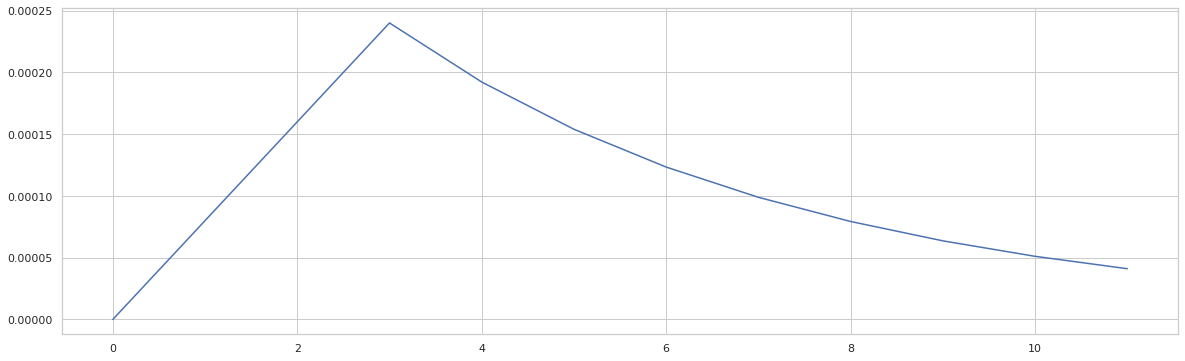

In [25]:
LEARNING_RATE = 3e-5 * strategy.num_replicas_in_sync
LR_START = 0.00000001
LR_MIN = 0.000001
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 12 # testing showed that the losses reach a minimum around 12 epochs, after that we get over-fitting

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## fine tuning the layers ##

In [26]:
model_path = 'DenseNet201_%sx%s.h5' % (HEIGHT, WIDTH)
ES_PATIENCE = 6

# unfreeze all layers
for layer in model.layers:
    layer.trainable = True

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
# early stopping is a regularization which we use to avoid overfitting. we set the number of iterations allowed
# to run before the learner begins over-fitting to the training data at the cost of the validation (or later, test) data.
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1) # 
lr_callback = LearningRateScheduler(lrfn, verbose=1) # set the learning rate according to the defined function

callback_list = [checkpoint, es, lr_callback]

optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metric_list)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 6, 6, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


## train the model ##

In [27]:
STEPS_PER_EPOCH = NUM_OVERSAMPLED_TRAINING_DATA // batchSize # used when using the oversampled data
history = model.fit(
    dataTrain,
    #dataTrainOversampled, # used when using the oversampled data
    validation_data=dataVal,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
).history # the ".history" at the end is needed to make the history object subscriptale so we can plot it later

Epoch 1/12
335/335 [==============================] - 148s 440ms/step - sparse_categorical_accuracy: 0.9346 - loss: 0.2598 - val_sparse_categorical_accuracy: 0.9106 - val_loss: 0.3657
Epoch 2/12
335/335 [==============================] - 56s 168ms/step - sparse_categorical_accuracy: 1.0000 - loss: 0.0027 - val_sparse_categorical_accuracy: 0.9146 - val_loss: 0.3494
Epoch 3/12
335/335 [==============================] - 58s 175ms/step - sparse_categorical_accuracy: 1.0000 - loss: 0.0012 - val_sparse_categorical_accuracy: 0.9143 - val_loss: 0.3550
Epoch 4/12
335/335 [==============================] - 58s 172ms/step - sparse_categorical_accuracy: 1.0000 - loss: 7.1788e-04 - val_sparse_categorical_accuracy: 0.9154 - val_loss: 0.3605
Epoch 5/12
335/335 [==============================] - 57s 170ms/step - sparse_categorical_accuracy: 1.0000 - loss: 4.7317e-04 - val_sparse_categorical_accuracy: 0.9146 - val_loss: 0.3663
Epoch 6/12
335/335 [==============================] - 57s 170ms/step - spars

## Plot the training results ##

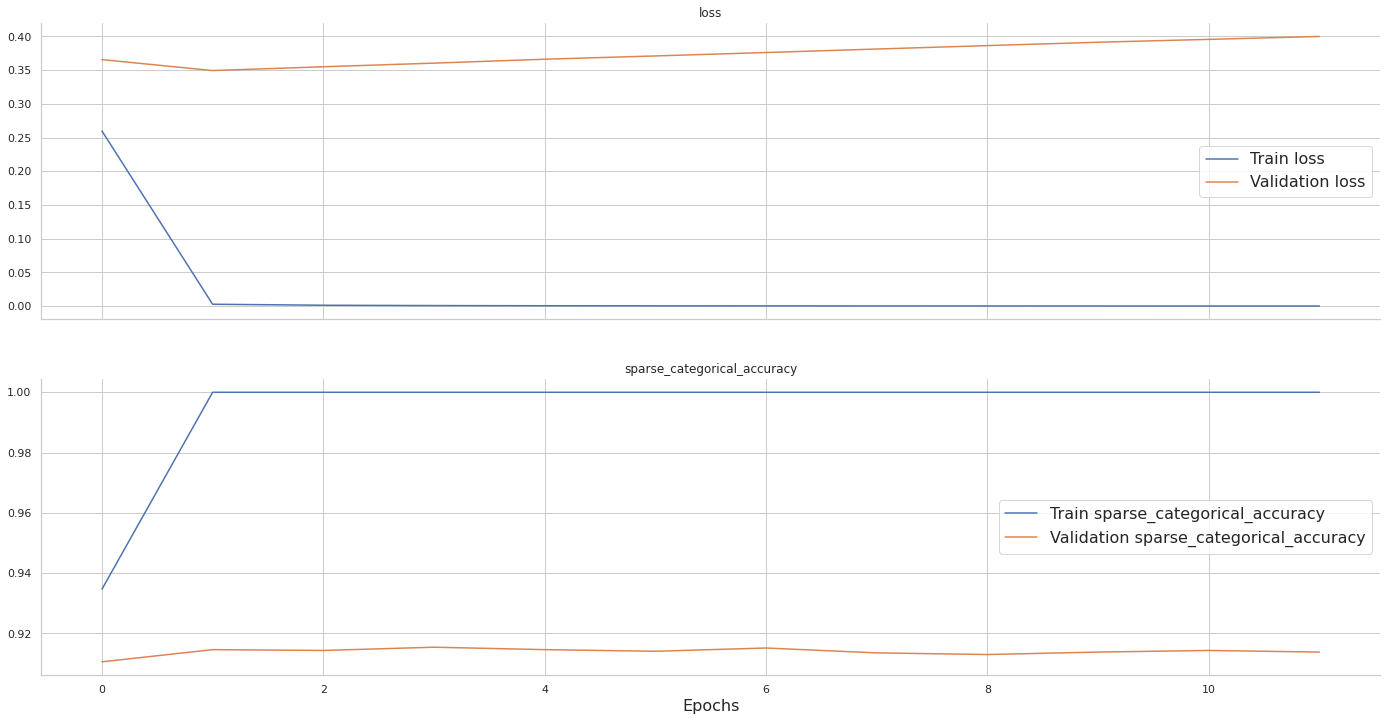

In [28]:
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(24, 12))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

plot_metrics(history, metric_list=['loss', 'sparse_categorical_accuracy'])

## plot the confusion matrix ##



In [29]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
# cmdataset = get_validation_dataset(ordered=True)
cmdataset = dataVal
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(numValImages))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

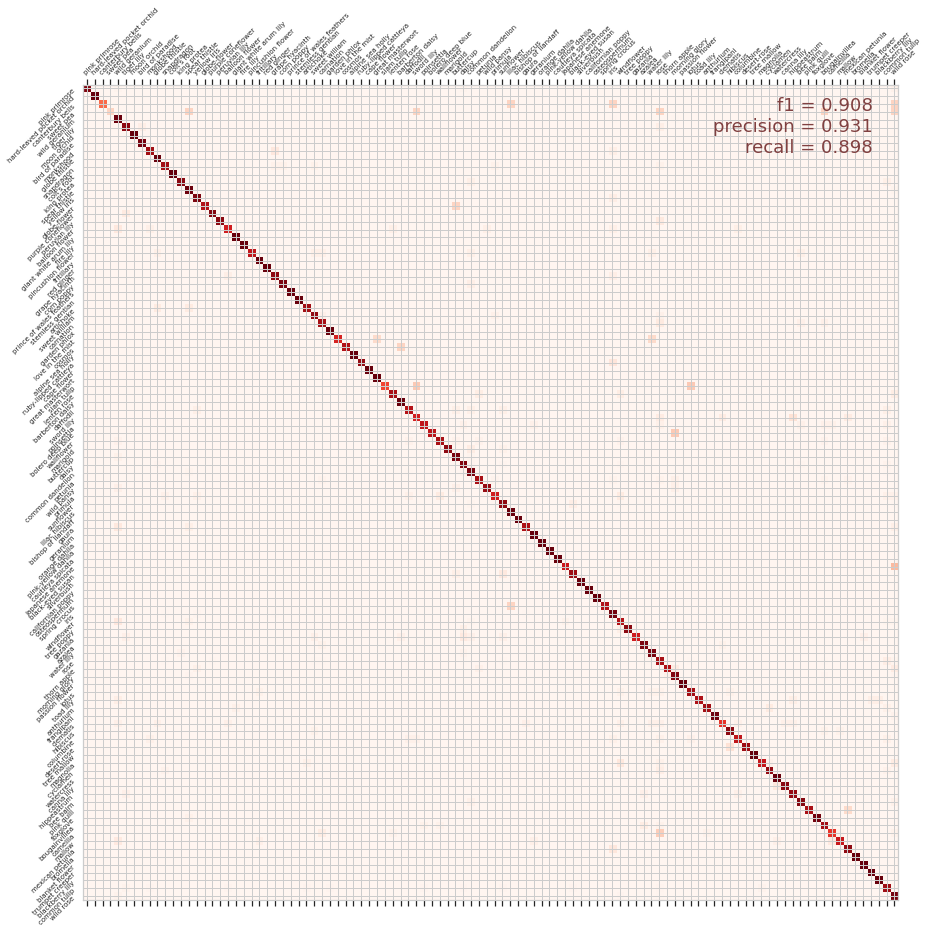

f1 =  0.908 precision =  0.931  recall =  0.898


In [30]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)
print("f1 = " , round(score,3) , "precision = ", round(precision,3), " recall = " , round(recall,3))

# results:

1.
epochs 12, resolution 192px-192px, model VGG16, no data augumentation
12-13s per epoch (except for the first one 34s)
sparse_categorical_accuracy: 0.5260 - loss: 2.0724 - val_sparse_categorical_accuracy: 0.5062 - val_loss: 2.1567
f1 = 0.396 precision = 0.543 recall = 0.361
remarks: poor results

2.
epochs 12, resolution 192px-192px, model Xception, no data augumentation
12s per epoch (except for the first one 37s)
sparse_categorical_accuracy: 0.8933 - loss: 0.4813 - val_sparse_categorical_accuracy: 0.7398 - val_loss: 1.0002
f1 = 0.733 precision = 0.794 recall = 0.706
remarks: Xception performs much better than VGG16

3.
epochs 12, resolution 192px-192px, model VGG16, data augumentation - up/down left/right flips, saturation [0,2], crop 1/8
11-13s per epoch (except for the first one 25s)
sparse_categorical_accuracy: 0.4658 - loss: 2.2505 - val_sparse_categorical_accuracy: 0.4300 - val_loss: 2.4010
f1 =  0.34 precision =  0.461  recall =  0.353
remarks: augumenting the data the way we did seemed to have made things worse

4.
epochs 12, resolution 192px-192px, model Xception, data augumentation - up/down left/right flips, saturation [0,2], crop 1/8
11-12s per epoch (except for the first one 26s)
sparse_categorical_accuracy: 0.7537 - loss: 0.9390 - val_sparse_categorical_accuracy: 0.7239 - val_loss: 1.0965, f1 =  0.704 precision =  0.782  recall =  0.671
remarks: augumenting the data the way we did seemed to have made things worse, also for Xception

5.
epochs 30, resolution 192px-192px, model Xception, data augumentation - up/down left/right flips, saturation [0,2], crop 1/8
11-12s per epoch (except for the first one 26s)
sparse_categorical_accuracy: 0.8236 - loss: 0.6586 - val_sparse_categorical_accuracy: 0.7357 - val_loss: 0.9989, f1 =  0.72 precision =  0.784  recall =  0.694
remarks: increasing the epochs from 12 to 30 did not help






6.
epochs 120, resolution 192px-192px, model VGG16, no data augumentation 11-12s per epoch (except for the first one 26s)
sparse_categorical_accuracy: 0.8164 - loss: 0.7671 - val_sparse_categorical_accuracy: 0.6897 - val_loss: 1.2356

7.
epochs 120, resolution 192px-192px, model XCeption, no data augumentation 12s per epoch
sparse_categorical_accuracy: 0.9999 - loss: 0.0072 - val_sparse_categorical_accuracy: 0.7395 - val_loss: 1.4572
remarks: train data accuracy and losses greatly improved and validation accuracy and losses slightly improved. Actually the validation accuracy and losses reached some optimum around 10-15 epochs and started degrading from there - overfitting. This shows that we only want 12 epochs.

8.
epochs 12, resolution 192px-192px, model DenseNet201, no data augumentation 12s per epoch
sparse_categorical_accuracy: 0.9523 - loss: 0.2620 - val_sparse_categorical_accuracy: 0.8295 - val_loss: 0.6651
remarks: so far the best model, better than XCeption

9.
3 warmup epochs with higher learning rate, epochs 12, resolution 192px-192px, model DenseNet201, no data augumentation 12s per epoch
20s 200ms/step - sparse_categorical_accuracy: 0.9938 - loss: 0.0298 - val_sparse_categorical_accuracy: 0.9003 - val_loss: 0.4495 f1 =  0.923 precision =  0.935  recall =  0.917
remarks: so far the best model

10. same but re-run from a different session
loss: 7.3095e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3543 - val_sparse_categorical_accuracy: 0.9186 , f1 =  0.914 precision =  0.931  recall =  0.906

11. still another session
sparse_categorical_accuracy: 1.0000 - loss: 6.8003e-05 - val_sparse_categorical_accuracy: 0.9138 - val_loss: 0.4000
f1 =  0.908 precision =  0.931  recall =  0.898






Look at examples from the dataset, with true and predicted classes.

In [31]:
# dataset = get_validation_dataset()
dataset = dataVal
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

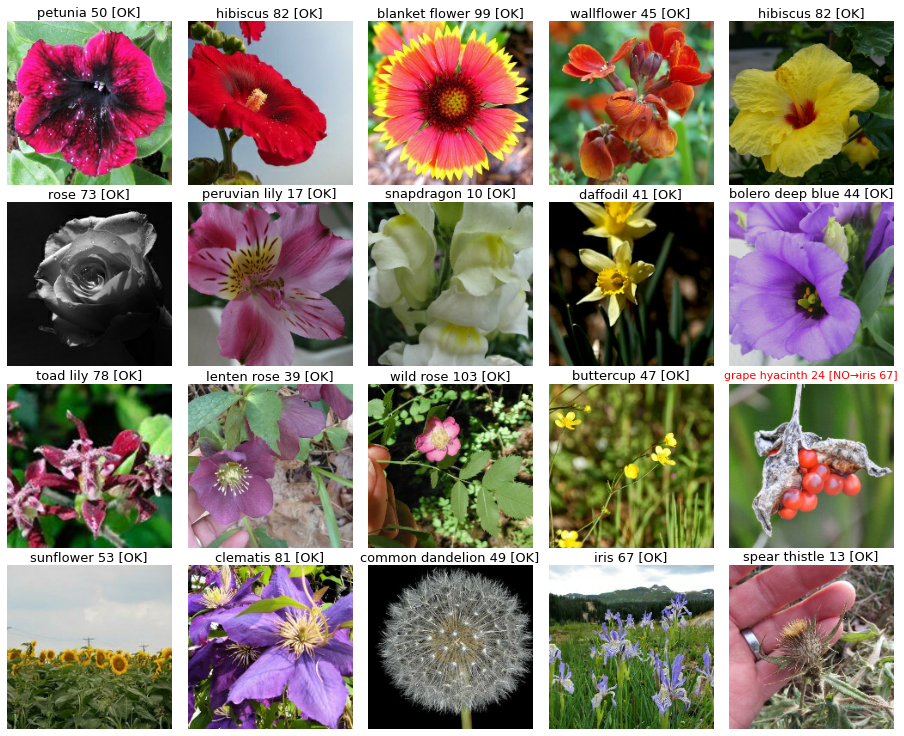

In [32]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

## Test Predictions ##

Create predictions to submit to the competition.

In [33]:
#test_ds = get_test_dataset(ordered=True)
test_ds = dataTest
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[67 52 81 ... 14 40 79]


In [34]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to integers
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(numTestImages))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
dfd946ac8,52
0c3ae4377,81
a31f90373,67
0bf251179,73
2dd56f346,69
d5320553f,68
e45a81eb4,4
6074e6638,43


# Summary #

In this project I learned about and worked with multiple topics:
- TPUs
- oversampling
- augmentation
- pretraining
- warmup layers
- variable learning function
- early stopping

specifically, I tried 3 different models with combinations of different augmentations, no augmentations, oversampling, no oversampling, pre-training and no pre-training.

The winning strategy was:
9. 3 warmup epochs with higher learning rate, epochs 12, resolution 192px-192px, model DenseNet201, no data augumentation 12s per epoch
20s 200ms/step - sparse_categorical_accuracy: 0.9938 - loss: 0.0298 - val_sparse_categorical_accuracy: 0.9003 - val_loss: 0.4495 f1 =  0.923 precision =  0.935  recall =  0.917